
BIDS dataset first and second level analysis
============================================

by Nilearn & Nistats Teams

modified/added by Ralf Schmaelzle

Full step-by-step example of fitting a GLM to perform a first and second level
analysis in a BIDS dataset and visualizing the results. Details about the BIDS
standard can be consulted at http://bids.neuroimaging.io/

More specifically:

1. Download an fMRI BIDS dataset with two language conditions to contrast.
2. Extract automatically from the BIDS dataset first level model objects
3. Fit a second level model on the fitted first level models. Notice that
   in this case the preprocessed bold images were already normalized to the
   same MNI space.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

%matplotlib inline

Fetch example BIDS dataset
--------------------------
We download an simplified BIDS dataset made available for illustrative
purposes. It contains only the necessary
information to run a statistical analysis using Nistats. The raw data
subject folders only contain bold.json and events.tsv files, while the
derivatives folder with preprocessed files contain preproc.nii and
confounds.tsv files.



In [4]:
from nistats.datasets import fetch_language_localizer_demo_dataset
data_dir, _ = fetch_language_localizer_demo_dataset()
data_dir

'/Users/Ralf/nilearn_data/fMRI-language-localizer-demo-dataset'

Obtain automatically FirstLevelModel objects and fit arguments
--------------------------------------------------------------
From the dataset directory we obtain automatically FirstLevelModel objects
with their subject_id filled from the BIDS dataset. Moreover we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the BIDS dataset.
To get the first level models we only have to specify the dataset directory
and the task_label as specified in the file names.



In [5]:
from nistats.first_level_model import first_level_models_from_bids
task_label = 'languagelocalizer'
models, models_run_imgs, models_events, models_confounds = \
    first_level_models_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

Quick sanity check on fit arguments
-----------------------------------
Additional checks or information extraction from pre-processed data can
be made here



We just expect one run img per subject.



In [6]:
import os
print([os.path.basename(run) for run in models_run_imgs[0]])

['sub-01_task-languagelocalizer_desc-preproc_bold.nii.gz']


The only confounds stored are regressors obtained from motion correction. As
we can verify from the column headers of the confounds table corresponding
to the only run_img present



In [7]:
print(models_confounds[0][0].columns)

Index(['RotX', 'RotY', 'RotZ', 'X', 'Y', 'Z'], dtype='object')


In [10]:
models_confounds[2][0].values.shape

(229, 6)

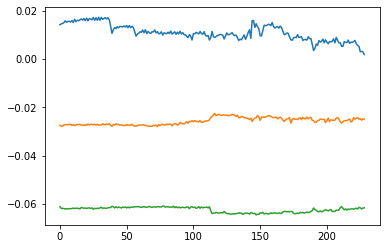

In [16]:
%matplotlib inline
plt.plot(models_confounds[2][0].values[:,0:3])

***Exercise:***

What is this? What does it mean?


Can you modify the code above to check what happened with this subject in the other confounds, and perhaps even in other subjects? If you succeed in doing so, you will learn about the datastructure.

During this acquisition the subject read blocks of sentences and
consonant strings. So these are our only two conditions in events.
We verify there are 12 blocks for each condition.



In [17]:
print(models_events[0][0]['trial_type'].value_counts())

language    12
string      12
Name: trial_type, dtype: int64


***Exercise:***

What again was a block?

First level model estimation
----------------------------
Now we simply fit each first level model and plot for each subject the
contrast that reveals the language network (language - string). Notice that
we can define a contrast using the names of the conditions specified in the
events dataframe. Sum, substraction and scalar multiplication are allowed.



Set the threshold as the z-variate with an uncorrected p-value of 0.001



In [18]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

***Exercise:***

What does norm.isf do?

Prepare figure for concurrent plot of individual maps (might take a while)



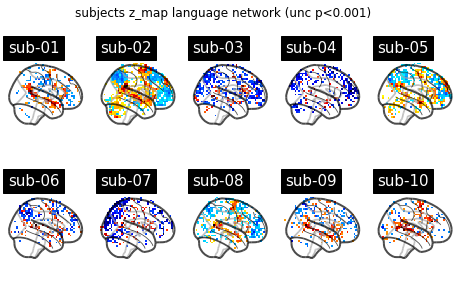

In [19]:
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4.5))
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
for midx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM
    model.fit(imgs, events, confounds)
    # compute the contrast of interest
    zmap = model.compute_contrast('language-string')
    plotting.plot_glass_brain(zmap, colorbar=False, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(midx / 5), int(midx % 5)],
                              plot_abs=False, display_mode='x')
fig.suptitle('subjects z_map language network (unc p<0.001)')
plotting.show()

Second level model estimation
-----------------------------
We just have to provide the list of fitted FirstLevelModel objects to the SecondLevelModel object for estimation. We can do this because all subjects share a similar design matrix (same variables reflected in column names)



In [20]:
from nistats.second_level_model import SecondLevelModel
second_level_input = models
second_level_input

[FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                 high_pass=0.01, hrf_model='glover', mask_img=None,
                 memory=Memory(location=None), memory_level=1, min_onset=-24,
                 minimize_memory=True, n_jobs=1, noise_model='ar1',
                 signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
                 standardize=False, subject_label='01', t_r=1.5,
                 target_affine=None, target_shape=None, verbose=0),
 FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                 high_pass=0.01, hrf_model='glover', mask_img=None,
                 memory=Memory(location=None), memory_level=1, min_onset=-24,
                 minimize_memory=True, n_jobs=1, noise_model='ar1',
                 signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
                 standardize=False, subject_label='02', t_r=1.5,
                 target_affine=None, target_shape=None, verbose=0),
 FirstLe

***Exercise:***

How many subjects again? 

Can you explain to your neighbor what will happen next?

#### Fitting the 2nd Level Model

Now we fit the model (drumroll)
Note that we apply a smoothing of 8mm.



In [21]:
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

Computing contrasts at the second level is as simple as at the first level
Since we are not providing confounders we are performing an one-sample test
at the second level with the images determined by the specified first level
contrast.



In [22]:
zmap = second_level_model.compute_contrast(
    first_level_contrast='language-string')

The group level contrast reveals a left lateralized fronto-temporal
language network



In [24]:
p001_unc

3.090232306167813


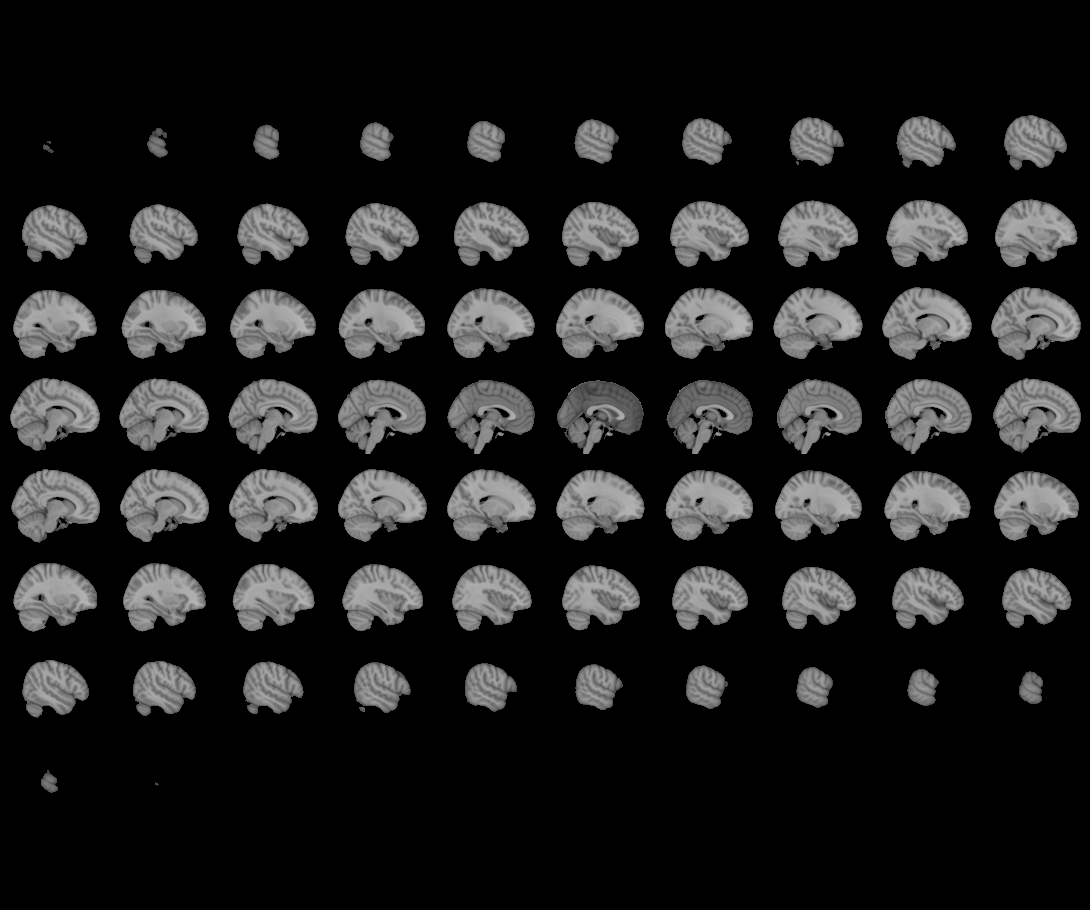
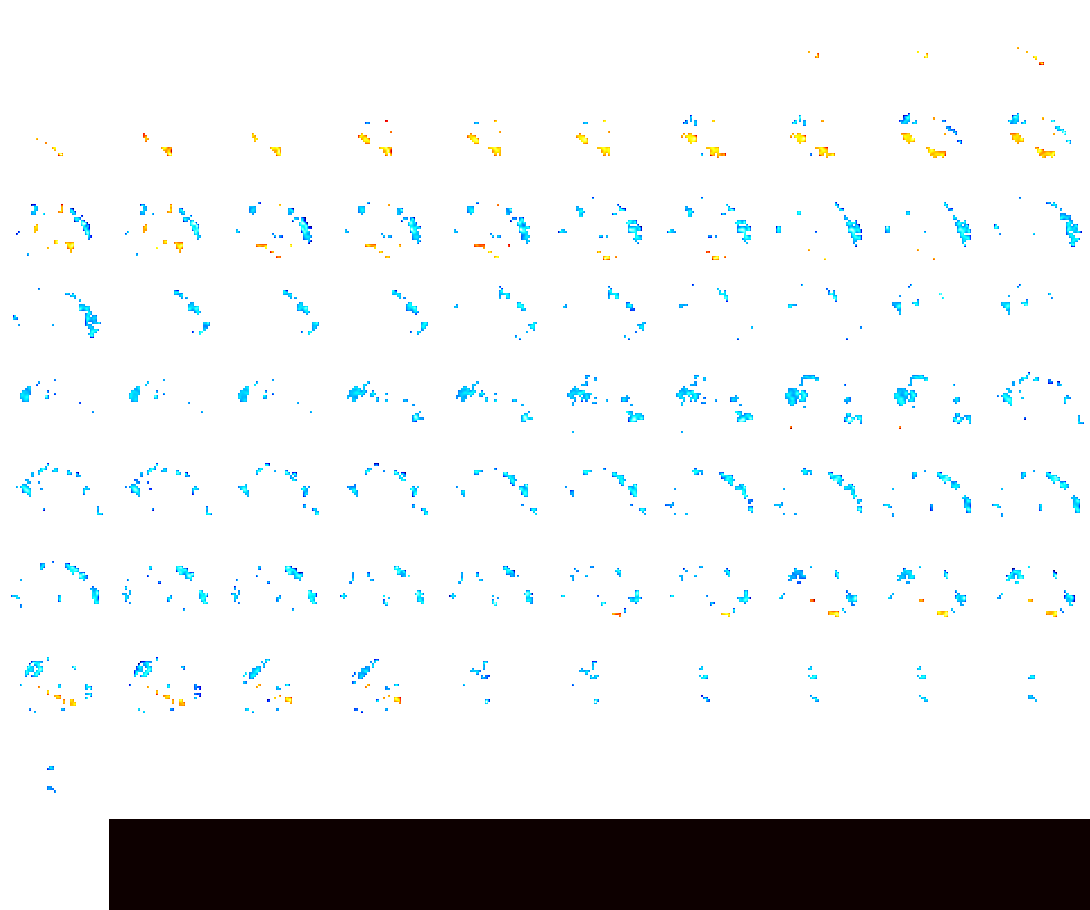

In [28]:
plotting.view_img(zmap, colorbar=True, threshold=3,
                          title='Group language network (unc p<0.0001)',
                          plot_abs=False, display_mode='x')


***Exercise:***

What do you see? 

What does this map show us? 

Can you change the threshold (e.g. to p < 0.0001 uncorrected)?